# Capstone: Supervised Learning

## Data Exploration
#### PBS KIDS Measure Up!

The Dataset contains anonymous gameplay data, including knowledge of videos watched and games played, from the PBS KIDS Measure Up! app.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy
import matplotlib.pyplot as plt
import warnings
%matplotlib inline

from scipy.stats.mstats import winsorize
from sklearn import ensemble
from sklearn import neighbors
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.svm import LinearSVC

warnings.filterwarnings('ignore')

In [2]:
#Read data from CSV
gameplay_raw = pd.read_csv('train.csv')
assessment_raw = pd.read_csv('train_labels.csv')

In [3]:
#View raw data
gameplay_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11341042 entries, 0 to 11341041
Data columns (total 11 columns):
event_id           object
game_session       object
timestamp          object
event_data         object
installation_id    object
event_count        int64
event_code         int64
game_time          int64
title              object
type               object
world              object
dtypes: int64(3), object(8)
memory usage: 951.8+ MB


In [4]:
assessment_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17690 entries, 0 to 17689
Data columns (total 7 columns):
game_session       17690 non-null object
installation_id    17690 non-null object
title              17690 non-null object
num_correct        17690 non-null int64
num_incorrect      17690 non-null int64
accuracy           17690 non-null float64
accuracy_group     17690 non-null int64
dtypes: float64(1), int64(3), object(3)
memory usage: 967.5+ KB


In [5]:
gameplay_raw.head(5)

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
0,27253bdc,45bb1e1b6b50c07b,2019-09-06T17:53:46.937Z,"{""event_code"": 2000, ""event_count"": 1}",0001e90f,1,2000,0,Welcome to Lost Lagoon!,Clip,NONE
1,27253bdc,17eeb7f223665f53,2019-09-06T17:54:17.519Z,"{""event_code"": 2000, ""event_count"": 1}",0001e90f,1,2000,0,Magma Peak - Level 1,Clip,MAGMAPEAK
2,77261ab5,0848ef14a8dc6892,2019-09-06T17:54:56.302Z,"{""version"":""1.0"",""event_count"":1,""game_time"":0...",0001e90f,1,2000,0,Sandcastle Builder (Activity),Activity,MAGMAPEAK
3,b2dba42b,0848ef14a8dc6892,2019-09-06T17:54:56.387Z,"{""description"":""Let's build a sandcastle! Firs...",0001e90f,2,3010,53,Sandcastle Builder (Activity),Activity,MAGMAPEAK
4,1bb5fbdb,0848ef14a8dc6892,2019-09-06T17:55:03.253Z,"{""description"":""Let's build a sandcastle! Firs...",0001e90f,3,3110,6972,Sandcastle Builder (Activity),Activity,MAGMAPEAK


In [6]:
assessment_raw.head(5)

,game_session,installation_id,title,num_correct,num_incorrect,accuracy,accuracy_group
0,6bdf9623adc94d89,0006a69f,Mushroom Sorter (Assessment),1,0,1.0,3
1,77b8ee947eb84b4e,0006a69f,Bird Measurer (Assessment),0,11,0.0,0
2,901acc108f55a5a1,0006a69f,Mushroom Sorter (Assessment),1,0,1.0,3
3,9501794defd84e4d,0006a69f,Mushroom Sorter (Assessment),1,1,0.5,2
4,a9ef3ecb3d1acc6a,0006a69f,Bird Measurer (Assessment),1,0,1.0,3


#### Installation IDs
From the data's source we know that installation_id corresponds to an application install on a device, which we'll assume to be a single child.

In [7]:
#Number of installation ID's contained in gameplay
gameplay_raw.installation_id.nunique()

17000

In [8]:
#Number of installation ID's contained in assessment data
assessment_IDs = assessment_raw.installation_id.unique()
len(assessment_IDs)

3614

We can see that the installation IDs from the gameplay group are not all in correspondence with those from the assessment group.  Meaning that some installation IDs never attempted an assesment.  Because the goal here is to use the gameplay data to forecast how many attempts a child will take to pass a given assessment, we are not interested in the data that does not correspond with an assessment.

In [9]:
#Create a copy of the assessment data in case you need to reload it
assessment_data = assessment_raw.copy()

In [10]:
#Create a new dataframe containing only the relevant instalation IDs for the assessment data
gameplay_data = gameplay_raw.copy()
gameplay_data = gameplay_data[gameplay_data['installation_id'].isin(assessment_IDs)]

In [11]:
len(gameplay_data.installation_id.unique())

3614

Ok, now we have the gameplay data that corresponds to the assessment data. Looking at the features we have to begin with are: event_id - identifier for event type; game_session - identifier for single session of gameplay; timestamp - generated in game timestamp; event_data - structured JSON string containing event data extracted in further features; event_count - counts "events" within game session; event_code - identifier of the event class; game_time - time in milliseconds since the start of the game session; title, type, and world.

Due to the amount of data in this set we're going to focus on the analysis of one world of the game for this project, MagmaPeak

In [12]:
#Isolate gameplay data for world: MagmaPeak
magma_gameplay_data = gameplay_data.loc[gameplay_data.world=='MAGMAPEAK']

In [13]:
#Number of installation ID's contained in MagmaPeak gameplay
magma_gameplay_data.installation_id.nunique()

3153

In [14]:
#Number of installation ID's contained in assessment data
assessment_data.installation_id.nunique()

3614

In [15]:
#Merge assessment data onto gameplay data of MagmaPeak
merged = magma_gameplay_data.merge(assessment_data, how='left', on=['installation_id', 'game_session'])

In [16]:
merged.shape

(3208242, 16)

In [17]:
magma_gameplay_data.shape

(3208242, 11)

In [18]:
merged.isnull().sum()*100/merged.isnull().count()

event_id            0.000000
game_session        0.000000
timestamp           0.000000
event_data          0.000000
installation_id     0.000000
event_count         0.000000
event_code          0.000000
game_time           0.000000
title_x             0.000000
type                0.000000
world               0.000000
title_y            94.612096
num_correct        94.612096
num_incorrect      94.612096
accuracy           94.612096
accuracy_group     94.612096
dtype: float64

In [19]:
merged

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title_x,type,world,title_y,num_correct,num_incorrect,accuracy,accuracy_group
0,27253bdc,4b57c9a59474a1b9,2019-08-06T04:57:45.301Z,"{""event_code"": 2000, ""event_count"": 1}",0006a69f,1,2000,0,Magma Peak - Level 1,Clip,MAGMAPEAK,NaN,NaN,NaN,NaN,NaN
1,77261ab5,2b9d5af79bcdb79f,2019-08-06T04:58:14.538Z,"{""version"":""1.0"",""event_count"":1,""game_time"":0...",0006a69f,1,2000,0,Sandcastle Builder (Activity),Activity,MAGMAPEAK,NaN,NaN,NaN,NaN,NaN
2,b2dba42b,2b9d5af79bcdb79f,2019-08-06T04:58:14.615Z,"{""description"":""Let's build a sandcastle! Firs...",0006a69f,2,3010,29,Sandcastle Builder (Activity),Activity,MAGMAPEAK,NaN,NaN,NaN,NaN,NaN
3,1325467d,2b9d5af79bcdb79f,2019-08-06T04:58:16.680Z,"{""coordinates"":{""x"":273,""y"":650,""stage_width"":...",0006a69f,3,4070,2137,Sandcastle Builder (Activity),Activity,MAGMAPEAK,NaN,NaN,NaN,NaN,NaN
4,1325467d,2b9d5af79bcdb79f,2019-08-06T04:58:18.474Z,"{""coordinates"":{""x"":863,""y"":237,""stage_width"":...",0006a69f,4,4070,3937,Sandcastle Builder (Activity),Activity,MAGMAPEAK,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3208237,28520915,5448d652309a6324,2019-09-22T02:07:27.562Z,"{""misses"":1,""prompt"":""holds least"",""mode"":""sel...",ffeb0b1b,58,2030,67094,Cauldron Filler (Assessment),Assessment,MAGMAPEAK,Cauldron Filler (Assessment),1.0,2.0,0.333333,1.0
3208238,91561152,5448d652309a6324,2019-09-22T02:07:27.562Z,"{""bucket"":1,""buckets_placed"":[3,1,2],""target_b...",ffeb0b1b,57,4025,67094,Cauldron Filler (Assessment),Assessment,MAGMAPEAK,Cauldron Filler (Assessment),1.0,2.0,0.333333,1.0
3208239,d3268efa,5448d652309a6324,2019-09-22T02:07:27.566Z,"{""description"":""Awesome."",""identifier"":""Dot_Aw...",ffeb0b1b,59,3021,67094,Cauldron Filler (Assessment),Assessment,MAGMAPEAK,Cauldron Filler (Assessment),1.0,2.0,0.333333,1.0
3208240,b5053438,5448d652309a6324,2019-09-22T02:07:28.311Z,"{""description"":""Awesome."",""identifier"":""Dot_Aw...",ffeb0b1b,60,3121,67847,Cauldron Filler (Assessment),Assessment,MAGMAPEAK,Cauldron Filler (Assessment),1.0,2.0,0.333333,1.0


In [20]:
merged.columns

Index(['event_id', 'game_session', 'timestamp', 'event_data',
       'installation_id', 'event_count', 'event_code', 'game_time', 'title_x',
       'type', 'world', 'title_y', 'num_correct', 'num_incorrect', 'accuracy',
       'accuracy_group'],
      dtype='object')

In [21]:
merged.dtypes

event_id            object
game_session        object
timestamp           object
event_data          object
installation_id     object
event_count          int64
event_code           int64
game_time            int64
title_x             object
type                object
world               object
title_y             object
num_correct        float64
num_incorrect      float64
accuracy           float64
accuracy_group     float64
dtype: object

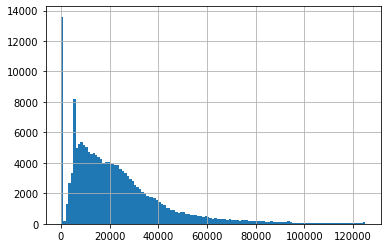

In [22]:
merged.loc[merged.type=='Assessment'].game_time.hist(range=(0,125000), bins=125)

## Feature Engineering

In [23]:
#Convert timestamp column to date time data type for sorting
merged.timestamp = pd.to_datetime(merged.timestamp)

In [24]:
#Sort data by time sequence
merged = merged.sort_values(by=['installation_id', 'timestamp'])

In [25]:
#Drop columns no longer needed
merged = merged.drop(columns = ['event_id', 'event_code', 'event_data', 'world', 'title_y', 'num_correct', 'num_incorrect', 'accuracy'])

In [26]:
#Create a rolling accumulation of eventcount
merged['cum_eventcount'] = merged.groupby('installation_id')['event_count'].cumsum()

In [27]:
#Create dummies to count total activities and clips
merged['activity'] = np.where(merged.type == 'Activity', 1, 0)
merged['clip'] = np.where(merged.type == 'Clip', 1, 0)

In [28]:
#Create a rolling count of activities and clips
merged['activities_completed'] = merged.groupby(['installation_id'])['activity'].cumsum()
merged['clips_watched'] = merged.groupby(['installation_id'])['clip'].cumsum()

In [29]:
#Take more recent value of game time by game session
merged = merged.loc[merged.groupby(['installation_id', 'game_session'])['game_time'].idxmax()]

In [30]:
#Create sum of game time by installation ID
merged['cum_gametime'] = merged.groupby('installation_id')['game_time'].cumsum()

In [31]:
#Create dataframe to add containing time spent per installation ID per title
add = merged.groupby(['installation_id', 'title_x'])['game_time'].sum()

In [32]:
add = add.reset_index()

In [33]:
add

,installation_id,title_x,game_time
0,0006a69f,Bottle Filler (Activity),486054
1,0006a69f,Bubble Bath,280660
2,0006a69f,Dino Dive,220678
3,0006a69f,Dino Drink,364830
4,0006a69f,Magma Peak - Level 1,0
...,...,...,...
21339,ffd2871d,Scrub-A-Dub,101533
21340,ffd2871d,Slop Problem,0
21341,ffeb0b1b,Cauldron Filler (Assessment),172700
21342,ffeb0b1b,Magma Peak - Level 1,0


In [34]:
add = add.pivot(index = 'installation_id', columns = 'title_x', values='game_time')

In [35]:
add.reset_index()

title_x,installation_id,Bottle Filler (Activity),Bubble Bath,Cauldron Filler (Assessment),Dino Dive,Dino Drink,Magma Peak - Level 1,Magma Peak - Level 2,Sandcastle Builder (Activity),Scrub-A-Dub,Slop Problem,Watering Hole (Activity)
0,0006a69f,486054.0,280660.0,NaN,220678.0,364830.0,0.0,0.0,414259.0,393797.0,0.0,246820.0
1,0006c192,395901.0,96656.0,14859.0,151986.0,NaN,0.0,0.0,339403.0,162878.0,NaN,21389.0
2,00129856,370036.0,NaN,NaN,NaN,NaN,NaN,NaN,109384.0,NaN,NaN,NaN
3,001d0ed0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,393790.0,NaN,NaN
4,00279ac5,604076.0,622311.0,NaN,567064.0,374095.0,0.0,0.0,727283.0,555255.0,0.0,339994.0
...,...,...,...,...,...,...,...,...,...,...,...,...
3148,ff9305d7,NaN,NaN,NaN,163984.0,245131.0,NaN,0.0,222519.0,NaN,NaN,NaN
3149,ff9715db,394989.0,NaN,34956.0,198204.0,NaN,NaN,0.0,304266.0,NaN,NaN,62921.0
3150,ffc90c32,141895.0,125674.0,17097.0,137438.0,99806.0,0.0,0.0,46787.0,827160.0,0.0,30174.0
3151,ffd2871d,1173709.0,287863.0,54533.0,207435.0,414150.0,0.0,0.0,329080.0,101533.0,0.0,NaN


In [36]:
#Fill NA values with 0 as if value is NA installation ID spent no time in that title
add=add.fillna(0)
add=add.drop(columns=['Cauldron Filler (Assessment)', 'Magma Peak - Level 1', 'Magma Peak - Level 2', 'Slop Problem'])

In [37]:
#Add title gametime to original DataFrame
merged = merged.merge(add, how='left', on=['installation_id'])

In [38]:
#Create training data - Isolate assessment data
train = merged.loc[merged.type=='Assessment']
train = train.drop(columns=['timestamp', 'game_session', 'event_count', 'game_time', 'title_x', 'type', 'activity', 'clip'])
train = train.dropna()

In [39]:
train

,installation_id,accuracy_group,cum_eventcount,activities_completed,clips_watched,cum_gametime,Bottle Filler (Activity),Bubble Bath,Dino Dive,Dino Drink,Sandcastle Builder (Activity),Scrub-A-Dub,Watering Hole (Activity)
35,0006c192,3.0,129536,760,4,14469,395901.0,96656.0,151986.0,0.0,339403.0,162878.0,21389.0
89,002db7e3,3.0,151438,896,5,765703,1626345.0,259079.0,380944.0,209658.0,152426.0,150522.0,94443.0
107,003372b0,3.0,23721,168,2,35975,147322.0,156537.0,155946.0,198487.0,73131.0,29144.0,4247.0
120,004c2091,3.0,962,51,3,36720,215135.0,0.0,18532.0,0.0,0.0,0.0,7339.0
126,004c2091,3.0,1592,51,3,299582,215135.0,0.0,18532.0,0.0,0.0,0.0,7339.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
48280,ff9715db,3.0,1275,0,0,995336,394989.0,0.0,198204.0,0.0,304266.0,0.0,62921.0
48286,ffc90c32,3.0,59801,211,4,1270183,141895.0,125674.0,137438.0,99806.0,46787.0,827160.0,30174.0
48305,ffd2871d,3.0,98080,561,2,2326284,1173709.0,287863.0,207435.0,414150.0,329080.0,101533.0,0.0
48310,ffeb0b1b,1.0,25984,381,3,132952,0.0,0.0,0.0,0.0,723991.0,0.0,0.0


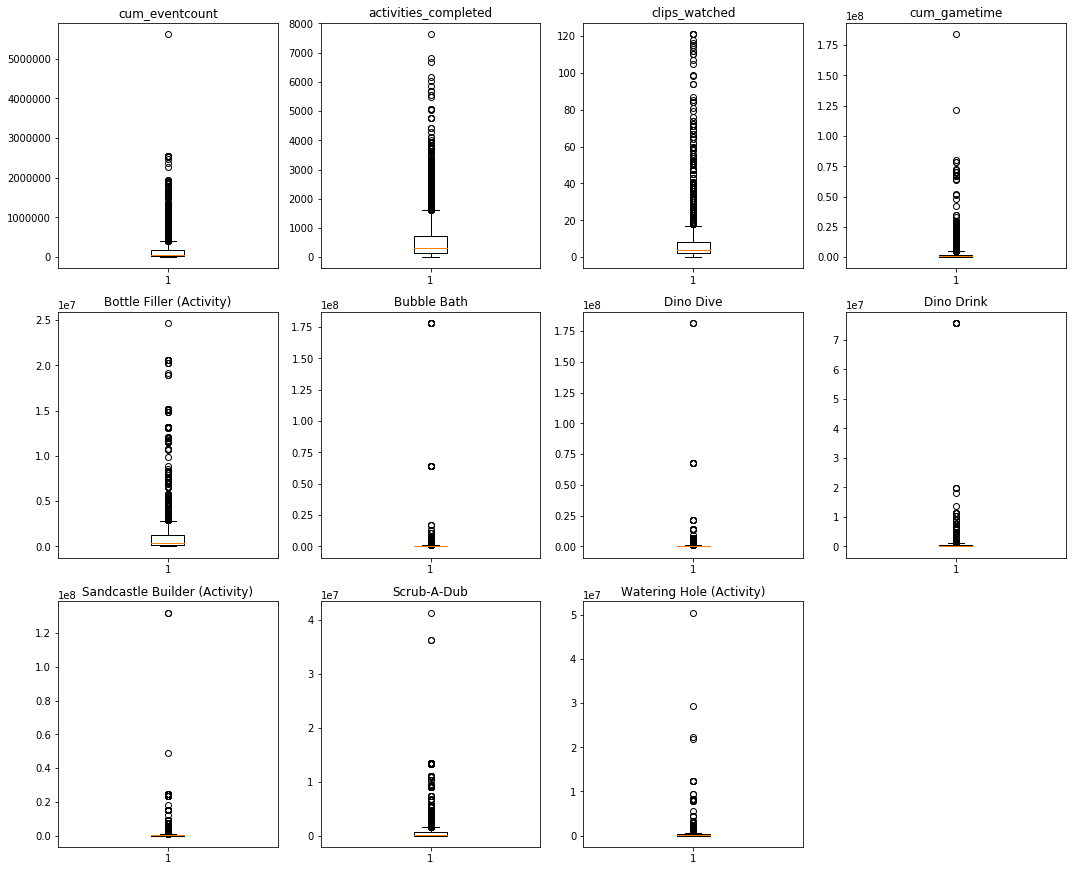

In [40]:
#Plot boxplots to view distribution of features
feats = ['cum_eventcount', 'activities_completed', 'clips_watched', 'cum_gametime','Bottle Filler (Activity)', 'Bubble Bath', 'Dino Dive', 'Dino Drink', 'Sandcastle Builder (Activity)', 'Scrub-A-Dub', 'Watering Hole (Activity)']

fig = plt.figure(figsize=(15,20))

n=0

for x in feats:
    n += 1
    plt.subplot(5 , 4, n)
    plt.boxplot(train[x])
    plt.title(x)
    
plt.tight_layout()
plt.show()

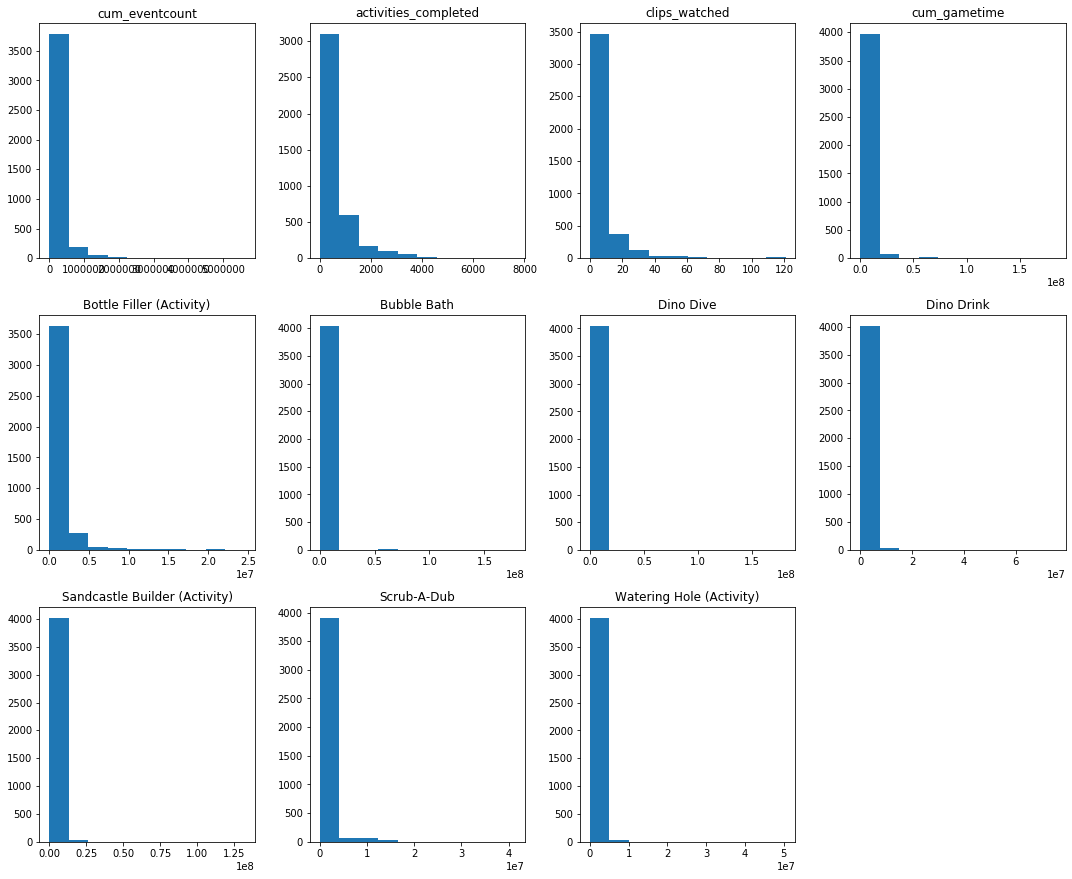

In [41]:
#Plot histograms to view distribution of features
fig = plt.figure(figsize=(15,20))

n=0

for x in feats:
    n += 1
    plt.subplot(5 , 4, n)
    plt.hist(train[x])
    plt.title(x)
    
plt.tight_layout()
plt.show()

In [42]:
train.describe()

,accuracy_group,cum_eventcount,activities_completed,clips_watched,cum_gametime,Bottle Filler (Activity),Bubble Bath,Dino Dive,Dino Drink,Sandcastle Builder (Activity),Scrub-A-Dub,Watering Hole (Activity)
count,4055.000000,4.055000e+03,4055.000000,4055.000000,4.055000e+03,4.055000e+03,4.055000e+03,4.055000e+03,4.055000e+03,4.055000e+03,4.055000e+03,4.055000e+03
mean,2.306782,1.647960e+05,586.812577,7.577559,2.578659e+06,1.113951e+06,9.361542e+05,6.705845e+05,6.031917e+05,6.345516e+05,7.555214e+05,3.185985e+05
std,1.030655,2.969792e+05,762.690186,11.723561,6.937918e+06,2.180188e+06,8.202309e+06,5.668462e+06,3.137407e+06,3.634555e+06,2.029212e+06,1.327141e+06
min,0.000000,1.110000e+02,0.000000,0.000000,5.989000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.000000,1.721300e+04,136.000000,2.000000,2.420115e+05,1.311520e+05,0.000000e+00,0.000000e+00,0.000000e+00,6.348300e+04,0.000000e+00,1.564000e+03
50%,3.000000,5.660400e+04,325.000000,4.000000,7.694570e+05,4.114250e+05,1.330630e+05,1.784540e+05,1.661290e+05,1.678430e+05,1.735340e+05,1.002260e+05
75%,3.000000,1.766165e+05,726.500000,8.000000,2.190356e+06,1.221339e+06,4.064790e+05,4.322060e+05,4.510060e+05,4.328610e+05,6.069500e+05,2.787415e+05
max,3.000000,5.624006e+06,7638.000000,121.000000,1.839375e+08,2.462958e+07,1.779972e+08,1.812326e+08,7.557361e+07,1.322170e+08,4.135642e+07,5.049628e+07


In [43]:
train.cum_eventcount.quantile([0, 0.02, 0.05, 0.25, 0.95, 0.97, 0.98, 0.99])

0.00        111.00
0.02        563.00
0.05       1595.50
0.25      17213.00
0.95     699831.00
0.97     986476.20
0.98    1114487.52
0.99    1533988.34
Name: cum_eventcount, dtype: float64

In [44]:
train.activities_completed.quantile([0, 0.02, 0.05, 0.25, 0.95, 0.97, 0.98, 0.99])

0.00       0.00
0.02       0.00
0.05       0.00
0.25     136.00
0.95    2194.00
0.97    2744.52
0.98    3115.84
0.99    3642.38
Name: activities_completed, dtype: float64

In [45]:
train.clips_watched.quantile([0, 0.02, 0.05, 0.25, 0.95, 0.97, 0.98, 0.99])

0.00     0.00
0.02     0.00
0.05     0.00
0.25     2.00
0.95    25.00
0.97    34.00
0.98    43.00
0.99    60.92
Name: clips_watched, dtype: float64

In [46]:
train.cum_gametime.quantile([0, 0.02, 0.05, 0.25, 0.95, 0.97, 0.98, 0.99])

0.00        5989.00
0.02       25292.56
0.05       32206.30
0.25      242011.50
0.95    10246429.00
0.97    16213884.40
0.98    19020561.12
0.99    25414684.76
Name: cum_gametime, dtype: float64

In [47]:
train['Bottle Filler (Activity)'].quantile([0, 0.02, 0.05, 0.25, 0.95, 0.97, 0.98, 0.99])

0.00           0.0
0.02           0.0
0.05           0.0
0.25      131152.0
0.95     4722086.0
0.97     6509729.0
0.98     7634901.0
0.99    11945110.0
Name: Bottle Filler (Activity), dtype: float64

In [48]:
train['Bubble Bath'].quantile([0, 0.02, 0.05, 0.25, 0.95, 0.97, 0.98, 0.99])

0.00          0.00
0.02          0.00
0.05          0.00
0.25          0.00
0.95    2334377.80
0.97    3294922.04
0.98    4488669.00
0.99    6571953.88
Name: Bubble Bath, dtype: float64

In [49]:
train['Dino Dive'].quantile([0, 0.02, 0.05, 0.25, 0.95, 0.97, 0.98, 0.99])

0.00          0.00
0.02          0.00
0.05          0.00
0.25          0.00
0.95    1437101.00
0.97    2523813.40
0.98    4035489.00
0.99    5289352.52
Name: Dino Dive, dtype: float64

In [50]:
train['Dino Drink'].quantile([0, 0.02, 0.05, 0.25, 0.95, 0.97, 0.98, 0.99])

0.00          0.0
0.02          0.0
0.05          0.0
0.25          0.0
0.95    1862122.2
0.97    3235206.0
0.98    4351005.0
0.99    7591960.0
Name: Dino Drink, dtype: float64

In [51]:
train['Sandcastle Builder (Activity)'].quantile([0, 0.02, 0.05, 0.25, 0.95, 0.97, 0.98, 0.99])

0.00          0.00
0.02          0.00
0.05          0.00
0.25      63483.00
0.95    1470886.00
0.97    2249793.26
0.98    4140634.00
0.99    9253313.88
Name: Sandcastle Builder (Activity), dtype: float64

In [52]:
train['Scrub-A-Dub'].quantile([0, 0.02, 0.05, 0.25, 0.95, 0.97, 0.98, 0.99])

0.00           0.0
0.02           0.0
0.05           0.0
0.25           0.0
0.95     3246005.0
0.97     5269119.0
0.98     8989916.0
0.99    11076480.0
Name: Scrub-A-Dub, dtype: float64

In [53]:
train['Watering Hole (Activity)'].quantile([0, 0.02, 0.05, 0.25, 0.95, 0.97, 0.98, 0.99])

0.00          0.0
0.02          0.0
0.05          0.0
0.25       1564.0
0.95    1012443.0
0.97    1456289.0
0.98    1792519.0
0.99    3173656.0
Name: Watering Hole (Activity), dtype: float64

In [54]:
#Apply one way winsorization and limit the higher end of the data to the 99th percentile
train['cum_eventcount'] = winsorize(train['cum_eventcount'], (0, 0.01))

#Apply one way winsorization and limit the higher end of the data to the 99th percentile
train['activities_completed'] = winsorize(train['activities_completed'], (0, 0.01))

#Apply one way winsorization and limit the higher end of the data to the 99th percentile
train['clips_watched'] = winsorize(train['clips_watched'], (0, 0.01))

#Apply one way winsorization and limit the higher end of the data to the 99th percentile
train['cum_gametime'] = winsorize(train['cum_gametime'], (0, 0.01))

#Apply one way winsorization and limit the higher end of the data to the 99th percentile
train['Bottle Filler (Activity)'] = winsorize(train['Bottle Filler (Activity)'], (0, 0.01))

#Apply one way winsorization and limit the higher end of the data to the 99th percentile
train['Bubble Bath'] = winsorize(train['Bubble Bath'], (0, 0.01))

#Apply one way winsorization and limit the higher end of the data to the 99th percentile
train['Dino Dive'] = winsorize(train['Dino Dive'], (0, 0.01))

#Apply one way winsorization and limit the higher end of the data to the 99th percentile
train['Dino Drink'] = winsorize(train['Dino Drink'], (0, 0.01))

#Apply one way winsorization and limit the higher end of the data to the 99th percentile
train['Sandcastle Builder (Activity)'] = winsorize(train['Sandcastle Builder (Activity)'], (0, 0.01))

#Apply one way winsorization and limit the higher end of the data to the 99th percentile
train['Scrub-A-Dub'] = winsorize(train['Scrub-A-Dub'], (0, 0.01))

#Apply one way winsorization and limit the higher end of the data to the 99th percentile
train['Watering Hole (Activity)'] = winsorize(train['Watering Hole (Activity)'], (0, 0.01))

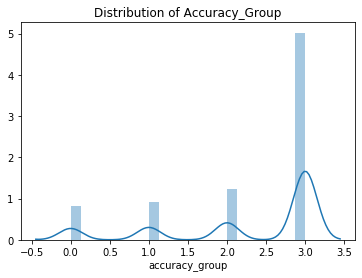

In [55]:
sns.distplot(train.accuracy_group)
plt.title('Distribution of Accuracy_Group')
plt.show()

In [56]:
#View correlation table
train.corr()

,accuracy_group,cum_eventcount,activities_completed,clips_watched,cum_gametime,Bottle Filler (Activity),Bubble Bath,Dino Dive,Dino Drink,Sandcastle Builder (Activity),Scrub-A-Dub,Watering Hole (Activity)
accuracy_group,1.000000,-0.070790,-0.037625,-0.147756,-0.046048,-0.040160,0.002335,-0.057774,-0.028009,-0.106824,-0.019565,-0.017220
cum_eventcount,-0.070790,1.000000,0.828669,0.573392,0.495831,0.471574,0.502350,0.373643,0.441311,0.286712,0.542767,0.549655
activities_completed,-0.037625,0.828669,1.000000,0.584537,0.515219,0.573296,0.443212,0.360438,0.343868,0.398955,0.477589,0.569060
clips_watched,-0.147756,0.573392,0.584537,1.000000,0.395922,0.318338,0.342639,0.272981,0.320065,0.345894,0.297914,0.371579
cum_gametime,-0.046048,0.495831,0.515219,0.395922,1.000000,0.550745,0.546682,0.410009,0.414695,0.371305,0.517824,0.491803
Bottle Filler (Activity),-0.040160,0.471574,0.573296,0.318338,0.550745,1.000000,0.360798,0.303847,0.290848,0.247115,0.330206,0.440765
Bubble Bath,0.002335,0.502350,0.443212,0.342639,0.546682,0.360798,1.000000,0.293955,0.266807,0.185728,0.555319,0.450310
Dino Dive,-0.057774,0.373643,0.360438,0.272981,0.410009,0.303847,0.293955,1.000000,0.368441,0.147496,0.409314,0.366224
Dino Drink,-0.028009,0.441311,0.343868,0.320065,0.414695,0.290848,0.266807,0.368441,1.000000,0.167927,0.284077,0.396245
Sandcastle Builder (Activity),-0.106824,0.286712,0.398955,0.345894,0.371305,0.247115,0.185728,0.147496,0.167927,1.000000,0.238273,0.359371


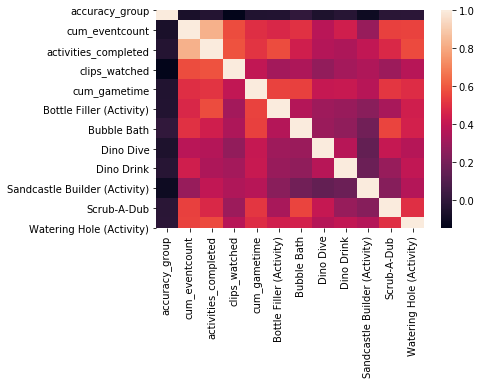

In [57]:
#View heatmap
sns.heatmap(train.corr())
plt.show()

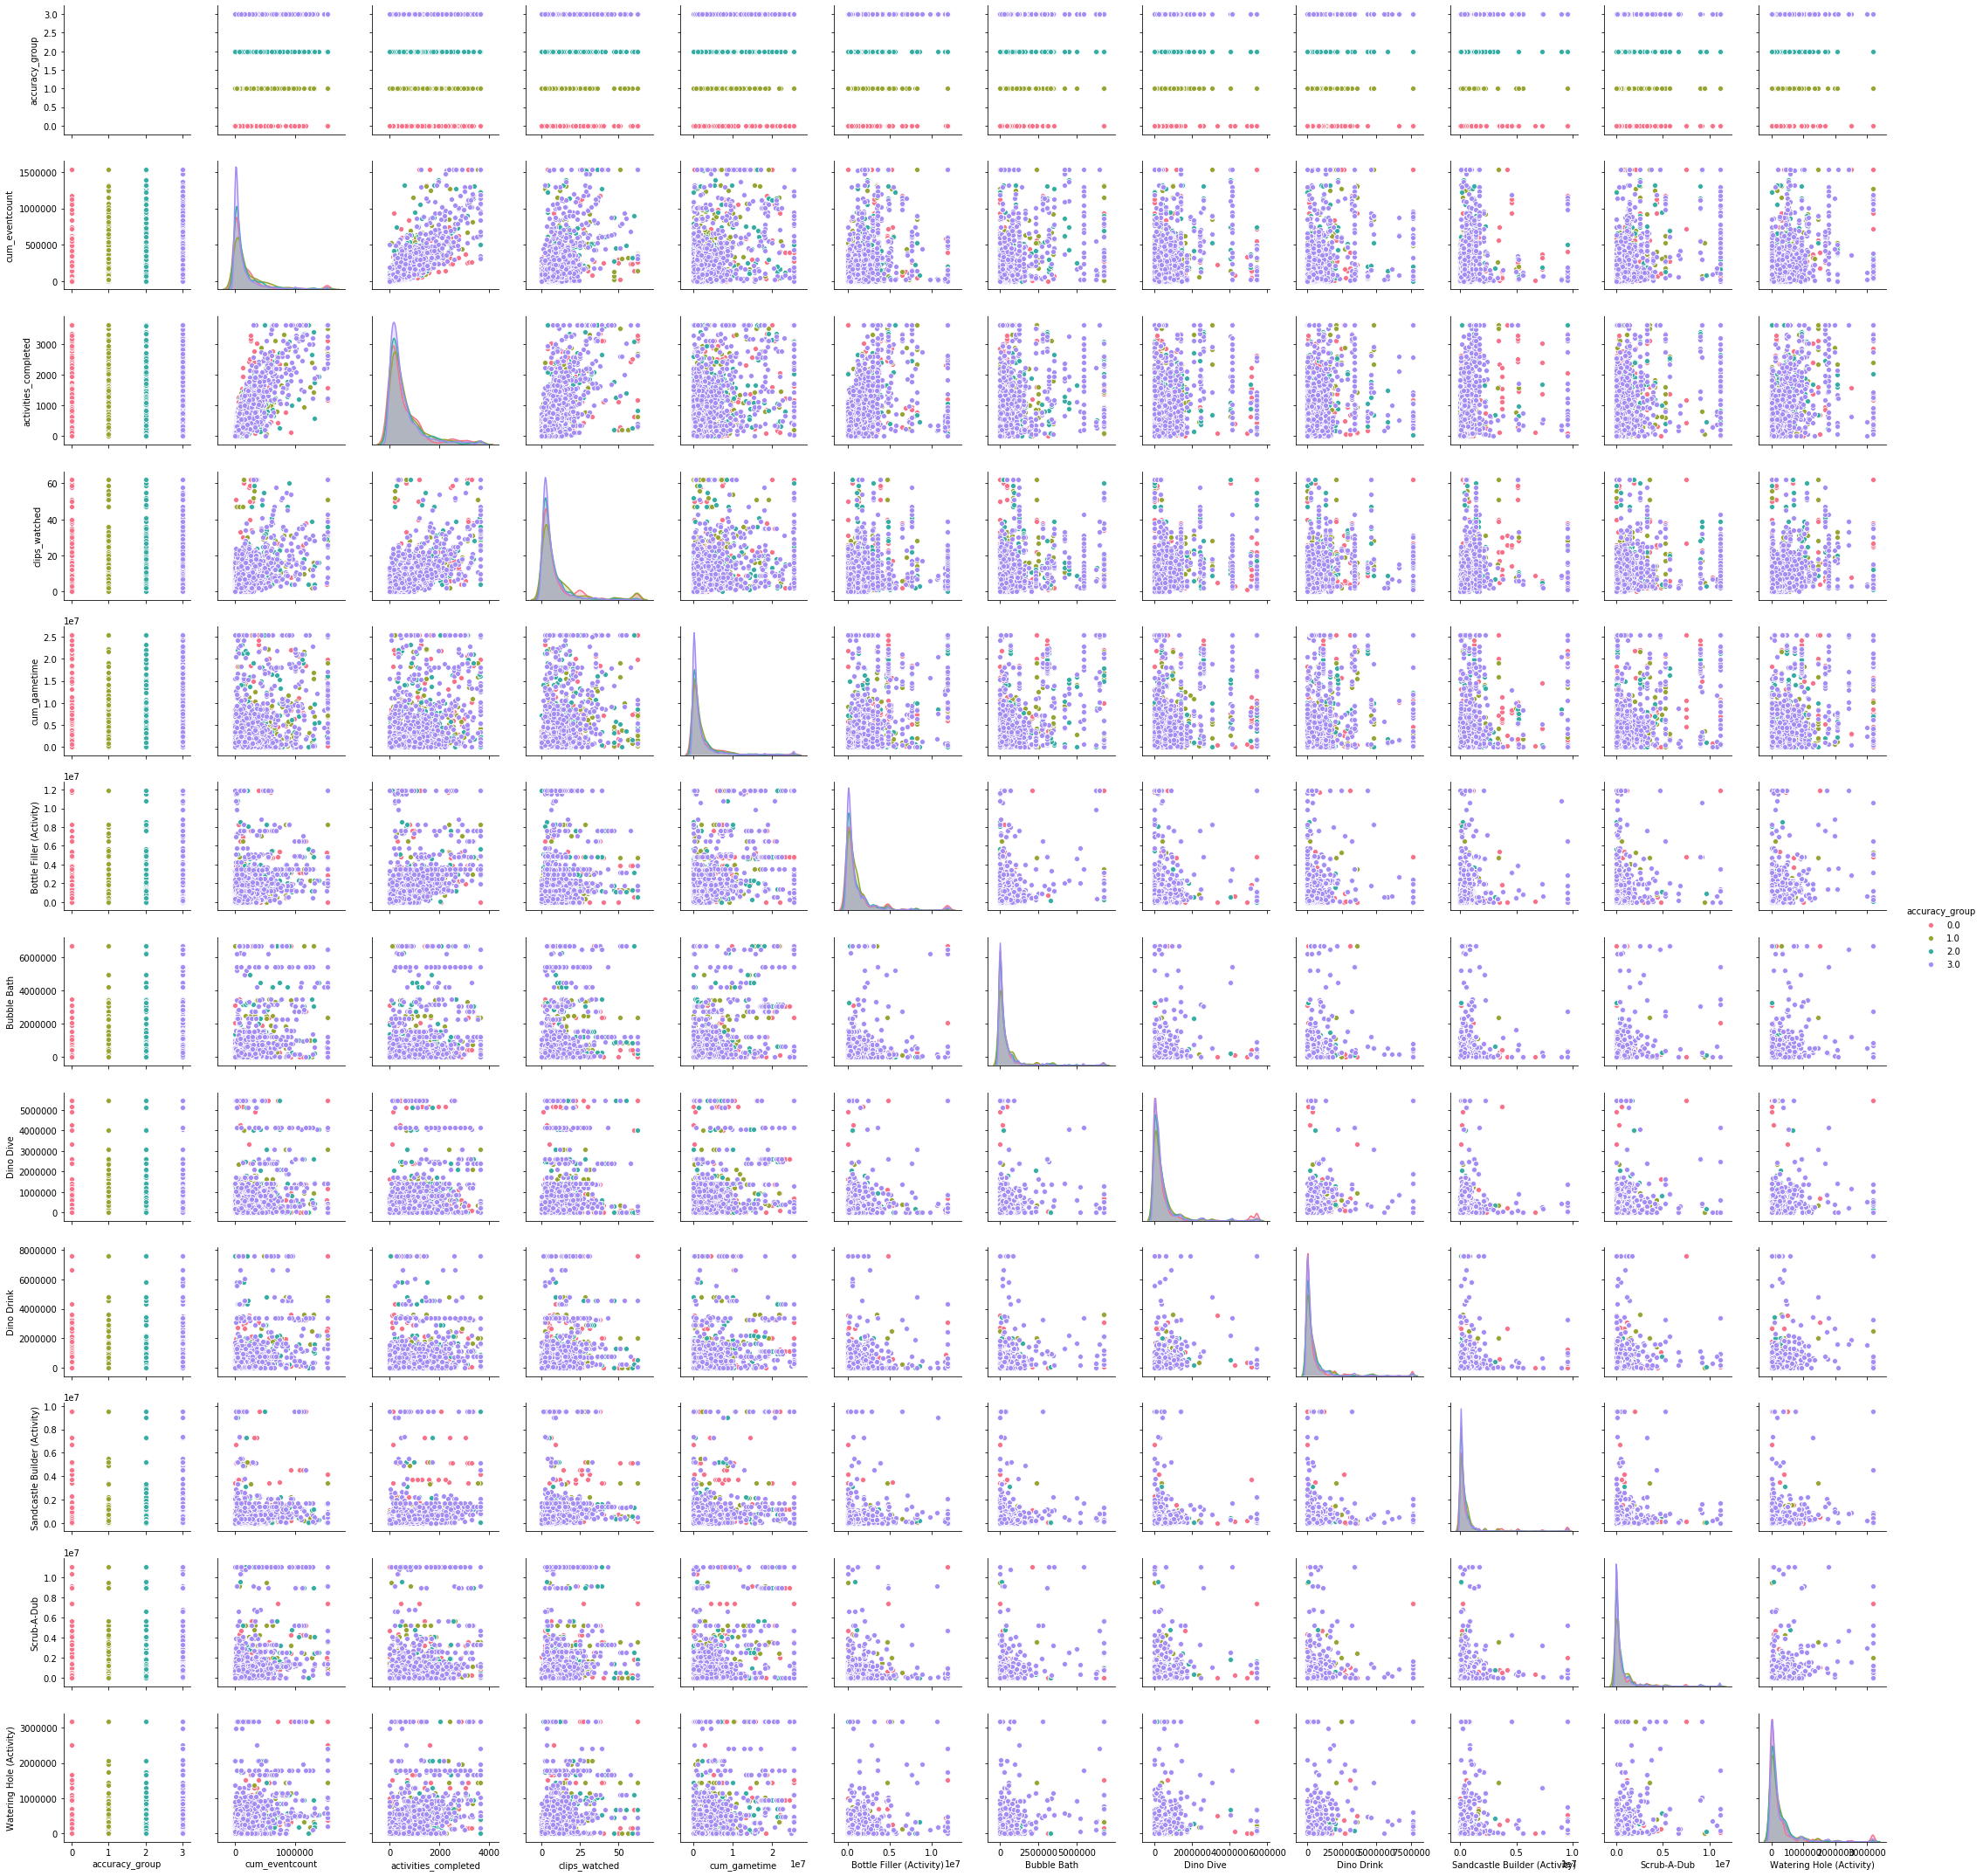

In [58]:
#Visual inspection of features vs accuracy group
sns.pairplot(train, hue='accuracy_group', palette='husl')
plt.show()

## Model Building

In [59]:
#Split into training and testing sets

X = train.drop(['accuracy_group', 'installation_id'], 1)
Y = train['accuracy_group']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

The number of observations in training set is 3244
The number of observations in test set is 811


### Random Forest Model

In [60]:
rfc = ensemble.RandomForestClassifier(n_estimators=150, min_samples_leaf=4, min_samples_split=6)

cross_val_score(rfc, X_train, y_train, cv=10)

array([0.65337423, 0.65337423, 0.63384615, 0.64      , 0.64615385,
       0.64615385, 0.65123457, 0.66563467, 0.64705882, 0.63975155])

In [61]:
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=6,
                       min_weight_fraction_leaf=0.0, n_estimators=150,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [62]:
predicted = rfc.predict(X_test)

In [63]:
accuracy_score(y_test, predicted)

0.6337854500616523

In [64]:
pd.crosstab(y_test, predicted)

col_0,0.0,1.0,2.0,3.0
accuracy_group,,,,
0.0,17,4,0,71
1.0,1,3,1,77
2.0,1,4,6,127
3.0,4,3,4,488


In [65]:
pd.DataFrame(rfc.feature_importances_,
            index = X_train.columns,
            columns=['importance']).sort_values('importance', ascending=False)

,importance
cum_eventcount,0.130148
cum_gametime,0.129195
Sandcastle Builder (Activity),0.106660
activities_completed,0.100334
Dino Dive,0.081160
Bottle Filler (Activity),0.080347
clips_watched,0.079561
Watering Hole (Activity),0.079158
Scrub-A-Dub,0.074728
Dino Drink,0.074034


### K-Nearest Neighbors Model

In [66]:
knn = neighbors.KNeighborsClassifier(n_neighbors=15, weights='distance')
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=15, p=2,
                     weights='distance')

In [67]:
cross_val_score(knn, X_train, y_train, cv=10)

array([0.61042945, 0.63496933, 0.63692308, 0.63076923, 0.62461538,
       0.60615385, 0.61728395, 0.61919505, 0.62848297, 0.59937888])

In [68]:
knnpred = knn.predict(X_test)

In [69]:
accuracy_score(y_test, knnpred)

0.623921085080148

In [70]:
pd.crosstab(y_test, knnpred)

col_0,0.0,1.0,2.0,3.0
accuracy_group,,,,
0.0,17,5,0,70
1.0,1,9,2,70
2.0,2,4,9,123
3.0,5,9,14,471


In [71]:
svc = LinearSVC()
svc.fit(X_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [72]:
cross_val_score(svc, X_train, y_train, cv=10)

array([0.29447853, 0.12576687, 0.54769231, 0.34769231, 0.24      ,
       0.11692308, 0.24382716, 0.22291022, 0.23219814, 0.45341615])

### Support Vector Machine

In [73]:
svcpred = svc.predict(X_test)

In [74]:
accuracy_score(y_test, svcpred)

0.5573366214549939

In [75]:
pd.crosstab(y_test, svcpred)

col_0,0.0,2.0,3.0
accuracy_group,,,
0.0,10,1,81
1.0,13,0,69
2.0,20,3,115
3.0,55,5,439
